In [49]:
from time import time
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Embedding, LSTM, GRU, Conv1D, Conv2D, GlobalMaxPool1D, Dense, Dropout, Layer
from tensorflow.python.keras.initializers import glorot_normal
from tensorflow.python.keras import regularizers

In [ ]:
#Two help function 
def padding(data):
    left = [] 
    maxlen= 50
    for i in range(data.shape[0]):
        diff = maxlen - len((data.iloc[i]['left']))
        if diff>=1:
            data.iloc[i]['left']+= [0]*diff
        left.append((data.iloc[i]['left']))
    right = [] 
    maxlen= 50
    for i in range(data.shape[0]):
        diff = maxlen - len((data.iloc[i]['right']))
        if diff>=1:
            data.iloc[i]['right']+= [0]*diff
        right.append((data.iloc[i]['right']))
    return np.array([right,left])


class ManDist(Layer):
    """
    Keras Custom Layer that calculates Manhattan Distance.
    """

    # initialize the layer, No need to include inputs parameter!
    def __init__(self, **kwargs):
        self.result = None
        super(ManDist, self).__init__(**kwargs)

    # input_shape will automatic collect input shapes to build layer
    def build(self, input_shape):
        super(ManDist, self).build(input_shape)

    # This is where the layer's logic lives.
    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    # return output shape
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

In [47]:
with open("Fulldata.txt", "rb") as fp:   # Unpickling
    df = pickle.load(fp)
X = df[['left','right']]     
Y = df['target']    
#Seperate to training, validation, and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 101)
validation_size = int(len(X_train) * 0.1)
training_size = len(X_train) - validation_size
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_size,random_state= 101)
Y_test = Y_test.values
Y_train = Y_train.values
Y_validation = Y_validation.values

print('Training size:',X_train.shape[0])
print('Validation size:',X_validation.shape[0])
print('test size:',X_test.shape[0])


#Check shape
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

X_train = padding(X_train)
X_validation = padding(X_validation)
#print(X_train.shape)

Training size: 14400
Validation size: 1600
test size: 4000


In [51]:
n_epoch = 50
n_hidden = 30
node_size = 201
seqlen = 50
embedding_dim = 50
batch_size = 32
learning_rate= 0.0001

# Define the shared model
x = Sequential()
x.add(Embedding(node_size, embedding_dim,
                input_length=seqlen,trainable=True))

# LSTM
x.add(LSTM(n_hidden,recurrent_initializer=glorot_normal(seed=None))) #return_sequences=True
#x.add(LSTM(n_hidden)) 
#x.add(Dense(16))
#x.add(Dense(2))
shared_model = x

# The visible layer
left_input = Input(shape=(seqlen,), dtype='int32')
right_input = Input(shape=(seqlen,), dtype='int32')

# Pack it all up into a Manhattan Distance model
malstm_distance = ManDist()([shared_model(left_input), shared_model(right_input)])
model = Model(inputs=[left_input, right_input], outputs=[malstm_distance])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=learning_rate,), metrics=['accuracy'])
model.summary()
shared_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 30)           19770       input_31[0][0]                   
                                                                 input_32[0][0]                   
__________________________________________________________________________________________________
man_dist_16 (ManDist)           (None, 1)            0           sequential_17[1][0]              
          

In [52]:
# Start trainings
training_start_time = time()
malstm_trained = model.fit([X_train[0], X_train[1]], Y_train,
                           batch_size=batch_size, epochs=n_epoch,
                           validation_data=([X_validation[0], X_validation[1]], Y_validation))
training_end_time = time()
print("Training time finished.\n%d epochs in %12.2f" % (n_epoch,
                                                        training_end_time - training_start_time))

Train on 14400 samples, validate on 1600 samples
Epoch 1/50
14400/14400 [==============================] - 33s 2ms/step - loss: 0.2999 - acc: 0.4994 - val_loss: 0.2841 - val_acc: 0.4950
Epoch 2/50
14400/14400 [==============================] - 30s 2ms/step - loss: 0.2796 - acc: 0.5016 - val_loss: 0.2669 - val_acc: 0.4975
Epoch 3/50
14400/14400 [==============================] - 27s 2ms/step - loss: 0.2690 - acc: 0.5042 - val_loss: 0.2720 - val_acc: 0.5012
Epoch 4/50
14400/14400 [==============================] - 25s 2ms/step - loss: 0.2656 - acc: 0.5047 - val_loss: 0.2633 - val_acc: 0.5031
Epoch 5/50
14400/14400 [==============================] - 25s 2ms/step - loss: 0.2643 - acc: 0.5078 - val_loss: 0.2616 - val_acc: 0.5088
Epoch 6/50
14400/14400 [==============================] - 25s 2ms/step - loss: 0.2618 - acc: 0.5092 - val_loss: 0.2648 - val_acc: 0.5038
Epoch 7/50
14400/14400 [==============================] - 26s 2ms/step - loss: 0.2607 - acc: 0.5126 - val_loss: 0.2656 - val_acc:

0.5056(max: 0.5156)
Done.


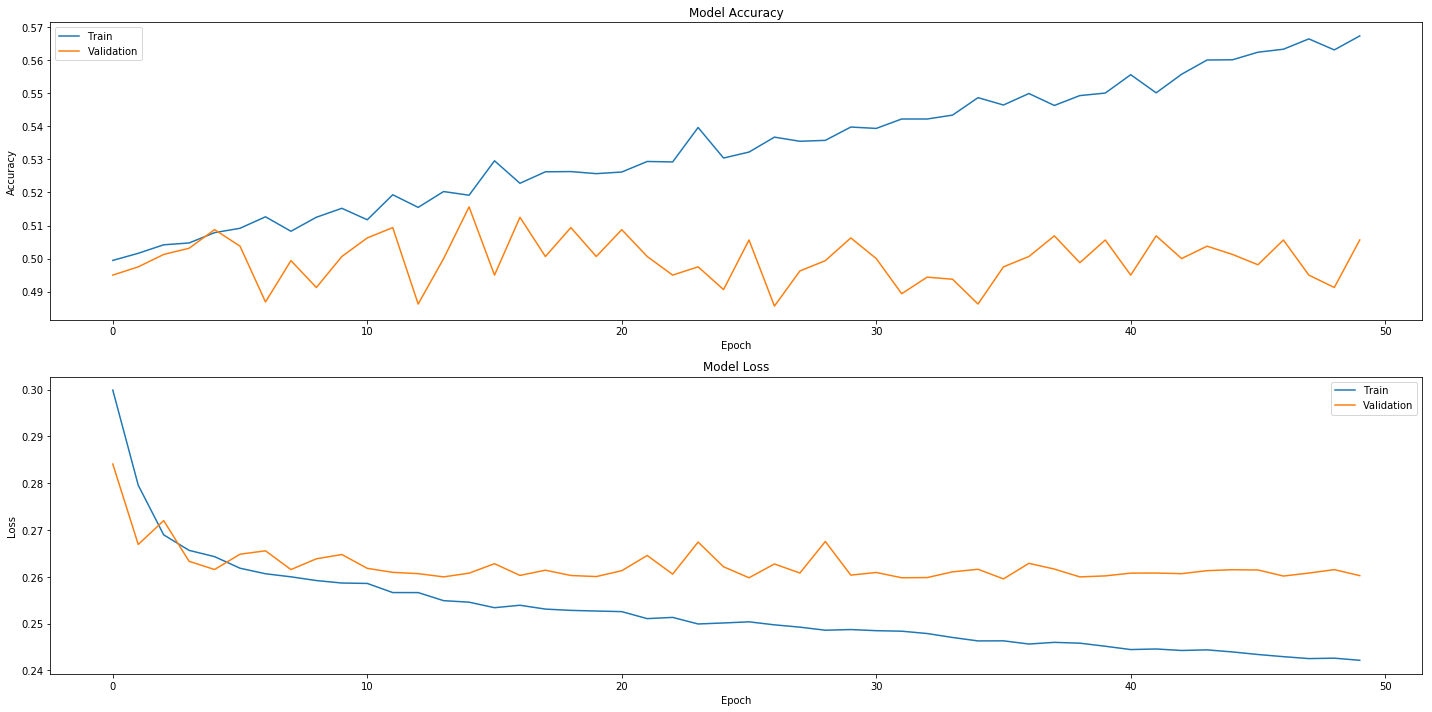

In [53]:
model.save('./Keras_model/FullDataOnlyLSTM1lr0.0001.h5')
fig, ax = plt.subplots(figsize= (20,10))
# Plot accuracy
plt.subplot(211)
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(212)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout(h_pad=1.0)
plt.savefig('./Keras_Results/FullDataOnlyLSTM1lr0.0001.png')

print(str(malstm_trained.history['val_acc'][-1])[:6] +
      "(max: " + str(max(malstm_trained.history['val_acc']))[:6] + ")")
print("Done.")